## Alternating least squares with QR decomposition

##### Bookkeeping 

In [1]:
## Import libraries

from cp_utils import *
#from np_utils import *
from cp_kernels import *
import cupy as cp
#import scipy
import serial_utils as SU
import numpy as np
import matplotlib.pyplot as plt

##### Consider a tensor of order 3. Generally such matrices are found in natural or synthetic data. We would like to decompose this tensor into the sum of outer products. This is similar to a singular value decomposition.

In [2]:

## Constructing a matrix from outer products
# Rank 1 matrix
dim1 = 5
dim2 = 5
A1 = cp.random.random(dim1,dtype=cp.float32)
A2 = cp.random.random(dim2,dtype=cp.float32)
M = cp.einsum('i,j->ij',A1,A2)


# Rank 3 matrix construction
rank = 3
dim1 = 5
dim2 = 5
A1 = cp.random.random((dim1,rank),dtype=cp.float32)  ## Kind of like U in SVD
A2 = cp.random.random((dim2,rank),dtype=cp.float32)  ## Kind of like V.T in SVD
M = cp.zeros((dim1,dim2))
for i in range(rank):
    M += cp.einsum('i,j->ij',A1[:,i],A2[:,i])

In [3]:
## Constructing a Tensor from outer products
# Rank 2 Tensor construction

rank = 2
dim1 = 3
dim2 = 4
dim3 = 5

A1 = cp.random.random((dim1,rank),dtype=cp.float32)
A2 = cp.random.random((dim2,rank),dtype=cp.float32)
A3 = cp.random.random((dim3,rank),dtype=cp.float32)
X = cp.zeros((dim1,dim2,dim3))
for i in range(rank):
    X += cp.einsum('i,j,k->ijk',A1[:,i],A2[:,i],A3[:,i])

### Alternating least squares is the inverse of this operation. Given X, find A1,A2,A3

In [4]:
## The algorithm: One iteration, for one mode of ALS

## Take a guess at the factor matrices A1,A2,A3...

A1_guess = cp.random.random((dim1,rank),dtype=cp.float32)
A3_guess = cp.random.random((dim3,rank),dtype=cp.float32)


KR = khatri_rao(A1,A3)
target_b = f_unfold(X, mode=1,order='C').T
A2_updated = cp.linalg.solve(KR.T@KR, KR.T@target_b).T

In [5]:
## What KR is doing---> 
## If A1 is indexed by i,r and A3 indexed by k,r then 
## KR(A1,A2) has dimensions (dim1*dim3, rank) and is indexed by (ik,r)
## Think of khatri rao as flattened outer product of the columns of A1, A3

print("Khatri rao shape: ",KR.shape)

## unfold will "squash" all dimensions in X except the one we are interested in
## in this case target_b has dims (dim1*dim3, dim2)
print("X unfolded shape: ",target_b.shape)

## Solve normal equations:
print("A2 updated shape: ",A2_updated.shape)


## Do other combinations until convergence...

Khatri rao shape:  (15, 2)
X unfolded shape:  (15, 4)
A2 updated shape:  (4, 2)


## Moving onto ALS-QR


In [6]:
### The idea is very similar to vanilla ALS, but we have to do other tensor 
### operations that are generally WAY more expensive to compute


## Do QR:
Q_A3,R_A3 = np.linalg.qr(A3)
Q_A1,R_A1 = np.linalg.qr(A1)


## Khatri rao...
V1 = khatri_rao(R_A3, R_A1)

## QR again...
Q,R = cp.linalg.qr(V1)

## Tensor matrix product TWICE
Y = cp.einsum('ijk,iw,ky->wjy',X,Q_A1,Q_A3)

## unfold, do a matrix product with Q
Y0 = f_unfold(Y,mode=1)
W= Y0@Q

## Backsolve
A2_updated = linalg.solve_triangular(R,W.T).T


## Naive serial C implementation
#### serial_utils.py, utils.c

In [7]:
### I can compile my C code and pass in numpy arrays!

In [8]:
%%bash
gcc -shared -o naive_c.so -fPIC utils.c

In [9]:
rank = 5
dim1 = 30
dim2 = 30
dim3 = 30

A1 = np.random.random((dim1,rank)).astype(np.float32)
A2 = np.random.random((dim2,rank)).astype(np.float32)
A3 = np.random.random((dim3,rank)).astype(np.float32)

sum = np.zeros((dim1,dim2,dim3),dtype=np.float32)
for i in range(rank):
    sum+= np.einsum('i,j,k->ijk',A1[:,i],A2[:,i],A3[:,i])
X=sum


In [10]:
## MAX error across all modes (we know the truth, since we constructed it)
QR_SERIAL  = SU.decompose_QR_SERIAL(X,verbose=True,max_iter=50,rank=5)

Epoch: 0 MAX Rel Error:  0.21413545
Epoch: 1 MAX Rel Error:  0.13681327
Epoch: 2 MAX Rel Error:  0.114701875
Epoch: 3 MAX Rel Error:  0.10344823
Epoch: 4 MAX Rel Error:  0.09694521
Epoch: 5 MAX Rel Error:  0.09115249
Epoch: 6 MAX Rel Error:  0.08520892
Epoch: 7 MAX Rel Error:  0.078794435
Epoch: 8 MAX Rel Error:  0.071678884
Epoch: 9 MAX Rel Error:  0.063710906
Epoch: 10 MAX Rel Error:  0.054923058
Epoch: 11 MAX Rel Error:  0.045690436
Epoch: 12 MAX Rel Error:  0.036886632
Epoch: 13 MAX Rel Error:  0.029684965
Epoch: 14 MAX Rel Error:  0.024716744
Epoch: 15 MAX Rel Error:  0.021598734
Epoch: 16 MAX Rel Error:  0.019576736
Epoch: 17 MAX Rel Error:  0.018129008
Epoch: 18 MAX Rel Error:  0.01699703
Epoch: 19 MAX Rel Error:  0.016058203
Epoch: 20 MAX Rel Error:  0.01524841
Epoch: 21 MAX Rel Error:  0.014530148
Epoch: 22 MAX Rel Error:  0.013879821
Epoch: 23 MAX Rel Error:  0.01328191
Epoch: 24 MAX Rel Error:  0.01272599
Epoch: 25 MAX Rel Error:  0.012204868
Epoch: 26 MAX Rel Error:  0.0117

# Cuda implementation


In [11]:
## Move everything to the GPU! 

A1 = cp.array(A1,dtype=cp.float32)
A2 = cp.array(A2,dtype =cp.float32)
A3 = cp.array(A3,cp.float32)

X = cp.zeros((dim1,dim2,dim3),dtype = cp.float32)
for i in range(rank):
    X += cp.einsum('i,j,k->ijk',A1[:,i],A2[:,i],A3[:,i])

In [12]:
## %%bash 
## nvidia-smi

In [13]:
CUDA_QR = decompose_QR_KERNELS(X,max_iter=50,verbose=True,rank=5)

Epoch: 0 Rel Error:  0.17207119
Epoch: 0 | Loss (A): 15.0907545 | Loss (B): 15.0907545 | Loss (C): 15.090754
Epoch: 1 Rel Error:  0.13165838
Epoch: 1 | Loss (A): 11.546525 | Loss (B): 11.546524 | Loss (C): 11.546524
Epoch: 2 Rel Error:  0.12037321
Epoch: 2 | Loss (A): 10.556808 | Loss (B): 10.556808 | Loss (C): 10.556808
Epoch: 3 Rel Error:  0.10758771
Epoch: 3 | Loss (A): 9.435512 | Loss (B): 9.435512 | Loss (C): 9.435512
Epoch: 4 Rel Error:  0.09578455
Epoch: 4 | Loss (A): 8.400366 | Loss (B): 8.400366 | Loss (C): 8.400367
Epoch: 5 Rel Error:  0.08718878
Epoch: 5 | Loss (A): 7.646512 | Loss (B): 7.646512 | Loss (C): 7.6465116
Epoch: 6 Rel Error:  0.08023016
Epoch: 6 | Loss (A): 7.036237 | Loss (B): 7.036237 | Loss (C): 7.036237
Epoch: 7 Rel Error:  0.072940506
Epoch: 7 | Loss (A): 6.3969293 | Loss (B): 6.3969297 | Loss (C): 6.3969293
Epoch: 8 Rel Error:  0.06518122
Epoch: 8 | Loss (A): 5.7164345 | Loss (B): 5.7164345 | Loss (C): 5.716435
Epoch: 9 Rel Error:  0.05763384
Epoch: 9 | Los

### How are these functions called?

- Look at serial and CUDA (serial_utils.py, utils.c, cp_utils.py,cp_kernels.py)

### It turns out that the overwhelming hot kernel is the tensor matrix product (surprised?)



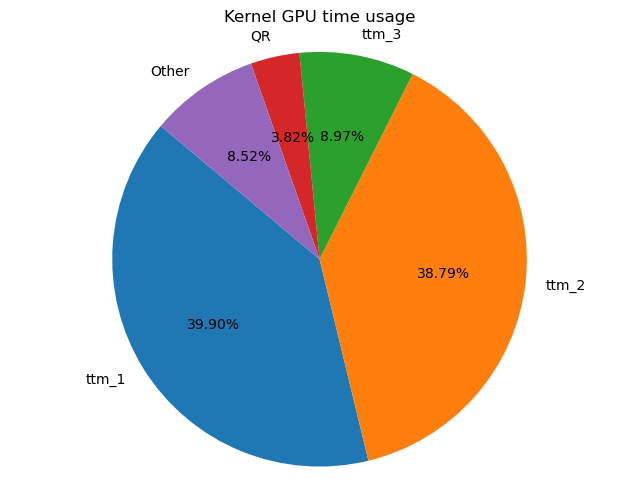

In [14]:
labels = ['ttm_1', 'ttm_2', 'ttm_3', 'QR','Other']
sizes = [39.90, 38.79, 8.97, 3.82,8.52]

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Kernel GPU time usage')
plt.show()